In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
from meas_data_preprocessing import *
from hydrophone_data_preprocessing import *
from PyDynamic.uncertainty.propagate_DFT import DFT_deconv, GUM_iDFT

# Load calibration data

In [3]:
meas_scenario = 13
infos, measurement_data = read_data(meas_scenario = meas_scenario)
_, hyd_data = read_calib_data(meas_scenario = meas_scenario, do_plot = False)

The file MeasuredSignals/pD-Mode 7 MHz/pD7_MH44.DAT was read and it contains 2500 data points.
The time increment is 2e-09 s


In [4]:
# metadata for chosen measurement scenario
for key in infos.keys():
    print("%20s: %s" %(key,infos[key]))

                   i: 13
       hydrophonname: GAMPT MH44
     measurementtype: Pulse-Doppler-Mode 7 MHz
     measurementfile: MeasuredSignals/pD-Mode 7 MHz/pD7_MH44.DAT
           noisefile: MeasuredSignals/pD-Mode 7 MHz/pD7_MH44r.DAT
         hydfilename: HydrophonCalibrationData/MW_MH44ReIm.csv


# Pre-process measurement data

In [5]:
# remove DC component
measurement_data = remove_DC_component(measurement_data)

In [6]:
# Calculate measurement uncertainty from noise data
measurement_data = uncertainty_from_noisefile(infos, measurement_data, do_plot=False)

The file "MeasuredSignals/pD-Mode 7 MHz/pD7_MH44r.DAT" was read and it contains 2500 data points


In [7]:
# calculate spectrum
measurement_data = calculate_spectrum(measurement_data, do_plot = False)

In [8]:
# available measurement data
for key in measurement_data.keys():
    print("%12s: %s"%(key, type(measurement_data[key])))

        name: <class 'str'>
     voltage: <class 'numpy.ndarray'>
        time: <class 'numpy.ndarray'>
 uncertainty: <class 'numpy.ndarray'>
   frequency: <class 'numpy.ndarray'>
    spectrum: <class 'numpy.ndarray'>
     varspec: <class 'numpy.ndarray'>


# Pre-process calibration data

In [9]:
# reduce frequency range of calibration data
hyd_data = reduce_freq_range(hyd_data, fmin = 1e6, fmax = 100e6)

In [10]:
# align spectrum of hydrophone frequency response with spectrum of measurement
fmeas = measurement_data["frequency"].round()
hyd_interp = interpolate_hyd(hyd_data, fmeas)

# Deconvolution in the frequency domain

In [11]:
# prepare matrix-vector notation for DFT_deconv
H_RI = np.r_[hyd_interp["real"],hyd_interp["imag"]]
U_HRI = np.r_[
    np.c_[np.diag(hyd_interp["varreal"]), hyd_interp["cov"]],
    np.c_[hyd_interp["cov"], np.diag(hyd_interp["varimag"])]]

# application of DFT_deconv
deconv = {"frequency": measurement_data["frequency"]}
deconv["P"], deconv["U_P"] = DFT_deconv(H_RI , measurement_data["spectrum"], U_HRI, measurement_data["varspec"])

Text(0, 0.5, 'Pressure p / Pa')

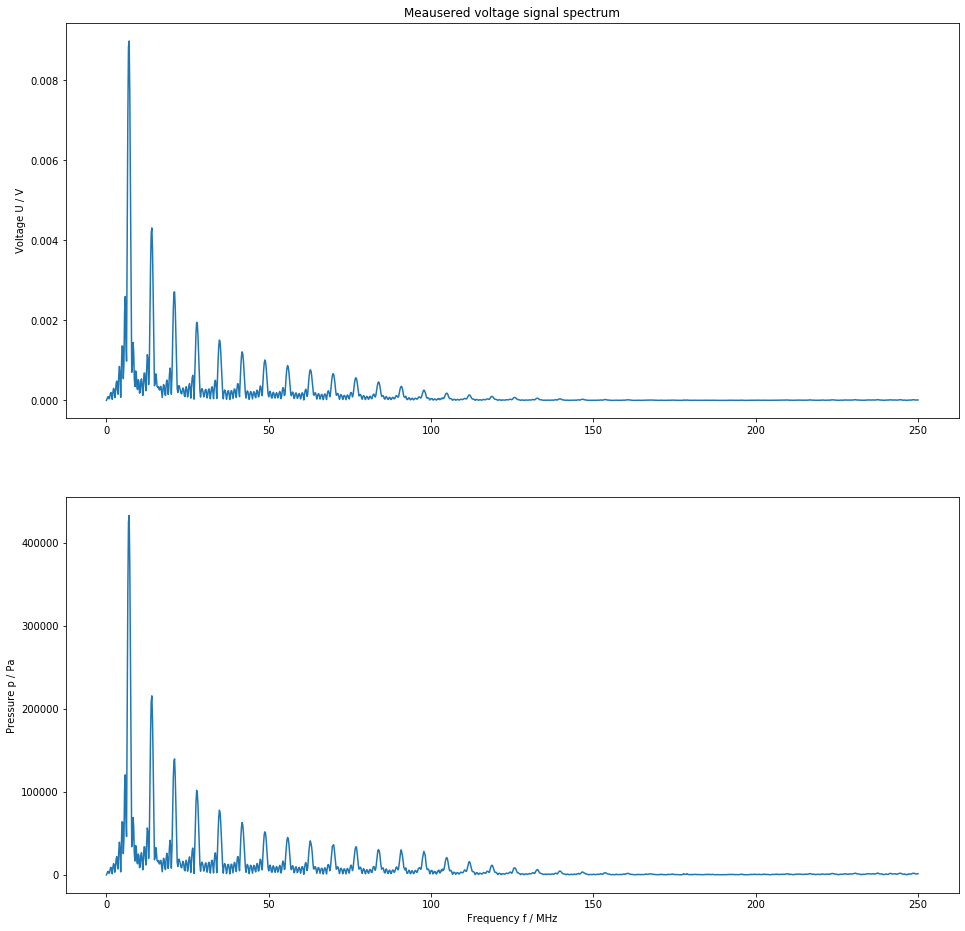

In [12]:
f = measurement_data["frequency"]
N = len(f)//2
figure(figsize=(16,16))
subplot(2,1,1)
plot(f[:N]/1E6, amplitude(measurement_data["spectrum"]))
title("Meausered voltage signal spectrum")
ylabel("Voltage U / V")

subplot(2,1,2)
plot(f[:N]/1e6, amplitude(deconv["P"]))
xlabel("Frequency f / MHz")
ylabel("Pressure p / Pa");

# Transformation to the time domain

In [13]:
deconvtime = {"t": measurement_data["time"]}
deconvtime["p"], deconvtime["Up"] = GUM_iDFT(deconv["P"], deconv["U_P"])

# correct for normalisation
deconvtime["p"] = deconvtime["p"]/2*np.size(deconvtime["t"])
deconvtime["Up"] = deconvtime["Up"]/4*np.size(deconvtime["t"])**2

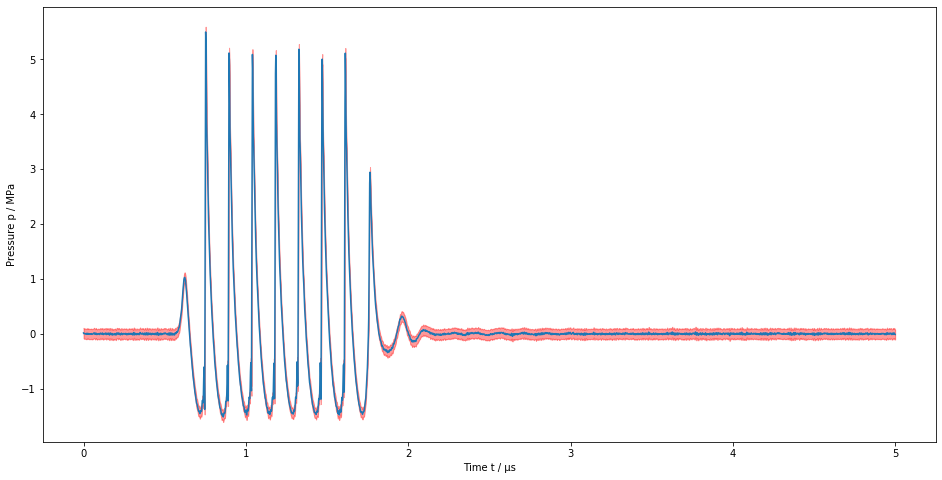

In [14]:
figure(figsize=(16,8))
plot(deconvtime["t"]/1E-6, deconvtime["p"]/1E6)
fill_between(deconvtime["t"]/1E-6, 
             deconvtime["p"]/1E6 - 2*np.sqrt(np.diag(deconvtime["Up"]))/1E6,
             deconvtime["p"]/1E6 + 2*np.sqrt(np.diag(deconvtime["Up"]))/1E6,
            color="red", alpha=0.4)
xlabel("Time t / µs")
ylabel("Pressure p / MPa");